In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
import gc
import time
import random
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from keras import backend as K
from keras.models import Sequential, load_model
from keras.optimizers import Adam, Nadam
from keras.initializers import glorot_uniform, lecun_uniform
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, Dropout, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping



Using TensorFlow backend.


Reduce Memmory Usage

In [3]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Load Data

In [4]:
%%time
train_ts=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
train_id=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
test_ts=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
test_id=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')

CPU times: user 52.9 s, sys: 5.18 s, total: 58 s
Wall time: 1min 12s


In [5]:
train_ts=reduce_mem_usage(train_ts)
train_id=reduce_mem_usage(train_id)
test_ts=reduce_mem_usage(test_ts)
test_id=reduce_mem_usage(test_id)

Memory usage of dataframe is 1775.15 MB --> 542.35 MB (Decreased by 69.4%)
Memory usage of dataframe is 45.12 MB --> 25.86 MB (Decreased by 42.7%)
Memory usage of dataframe is 1519.24 MB --> 472.59 MB (Decreased by 68.9%)
Memory usage of dataframe is 44.39 MB --> 25.44 MB (Decreased by 42.7%)


# Review Data

In [6]:
print('shape of train transaction is{}'.format(train_ts.shape))
print('shape of train identity is{}'.format(train_id.shape))
print('shape of test transaction is{}'.format(test_ts.shape))
print('shape of test identity is{}'.format(train_ts.shape))


shape of train transaction is(590540, 394)
shape of train identity is(144233, 41)
shape of test transaction is(506691, 393)
shape of test identity is(590540, 394)


In [7]:
train_ts.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [9]:
test_ts.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
test_id.head()

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


check the different between test and train data

In [11]:
print([col for col in train_ts.columns if col not in test_ts.columns])

['isFraud']


it is make sense, because it is target of this model

In [12]:
print([col for col in train_id.columns if col not in test_id.columns])

['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


making same name of columns of test_id with train_id

In [13]:
del_col=test_id[test_id.columns[-2:]]
test_id.drop(test_id.columns[-2:], axis=1, inplace=True)
for i in range(1,10):
    test_id['id_0'+str(i)]=test_id['id-0'+str(i)]
    test_id.drop('id-0'+str(i), axis=1, inplace=True)
for i in range(10,39):
    test_id['id_'+str(i)]=test_id['id-'+str(i)]
    test_id.drop('id-'+str(i), axis=1, inplace=True)
test_id[['DeviceType', 'DeviceInfo']]=del_col
print([col for col in train_id.columns if col not in test_id.columns])

[]


train id columns name is same with test id columns name

Making the target

In [14]:
labels = train_ts['isFraud']

# EDA and Cleansing

**Null Check**

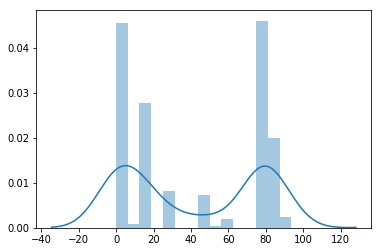

In [15]:
missing_ts_data=train_ts.isna().sum()/train_ts.shape[0]*100
xlim=(0,120)
sns.distplot(missing_ts_data,bins=15)

There are many data having missing value more than 70%. So we drop this columns

In [16]:
big_null_ts=[col for col in train_ts.columns 
                   if train_ts[col].isna().sum()/train_ts.shape[0]>0.70]
train_ts.drop(big_null_ts, axis=1, inplace=True)
train_ts.shape

(590540, 226)

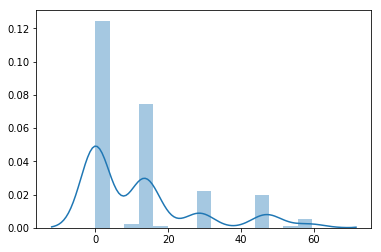

In [17]:
missing_id_data=train_ts.isna().sum()/train_ts.shape[0]*100
xlim=(0,120)
sns.distplot(missing_id_data,bins=15)

In [18]:
big_null_id=[col for col in train_id.columns 
                   if train_id[col].isna().sum()/train_id.shape[0]>0.70]
train_id.drop(big_null_id, axis=1, inplace=True)
train_id.shape

(144233, 32)

**check distribution of isFraud

,0,1
isFraud,0.96501,0.03499


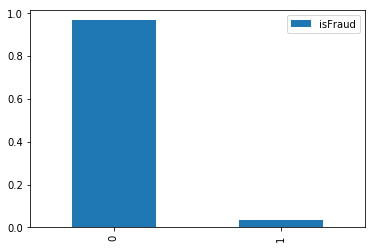

In [19]:
fraud_count = labels.value_counts(normalize=True).to_frame()
fraud_count.plot.bar()
fraud_count.T

There is a significant interval between total of Fraud and not-fraud. It will effect the model because many data is not-fraud. The model will detect many test data as not-fraud. but now we leave this for after few analyzing

**Transaction DT**

In information of this competition, they inform us that TransactionDT is time delta or time interval, but we still don't know it is in second or minutes or hour. we should check it

In [20]:
delta_time=train_ts['TransactionDT'].max()-train_ts['TransactionDT'].min()
print(delta_time/(60*60*24*30))

6.066640046296296


The possible unit of TransactionDT is in month and there is six month in data. For this, we add hour and days time to train_ts data

In [21]:
def make_day_feature(df, offset=0, tname='TransactionDT'):
    """
    Creates a day of the week feature, encoded as 0-6. 
    
    Parameters:
    -----------
    df : pd.DataFrame
        df to manipulate.
    offset : float (default=0)
        offset (in days) to shift the start/end of a day.
    tname : str
        Name of the time column in df.
    """
    # found a good offset is 0.58
    days = df[tname] / (3600*24)        
    encoded_days = np.floor(days-1+offset) % 7
    return encoded_days

def make_hour_feature(df, tname='TransactionDT'):
    """
    Creates an hour of the day feature, encoded as 0-23. 
    
    Parameters:
    -----------
    df : pd.DataFrame
        df to manipulate.
    tname : str
        Name of the time column in df.
    """
    hours = df[tname] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

In [22]:
train_ts['days']=make_day_feature(train_ts, offset=0.58)
train_ts['hour']=make_hour_feature(train_ts)
train_ts.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V314,V315,V316,V317,V318,V319,V320,V321,days,hour
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
test_ts['days']=make_day_feature(test_ts, offset=0.58)
test_ts['hour']=make_hour_feature(test_ts)
test_ts.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V332,V333,V334,V335,V336,V337,V338,V339,days,hour
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0


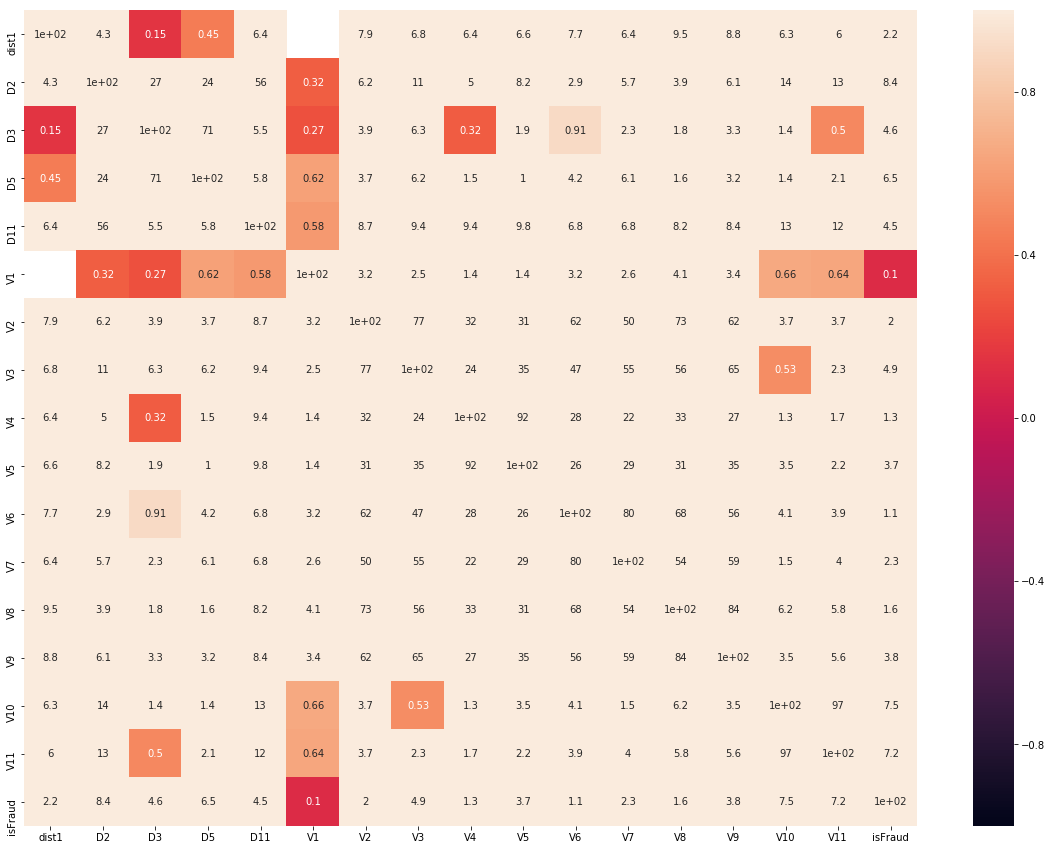

In [24]:
import matplotlib.pyplot as plt
middle_nul_ts=big_null_ts=[col for col in train_ts.columns 
                   if train_ts[col].isna().sum()/train_ts.shape[0]>0.40]
merging_data1 = train_ts[middle_nul_ts].merge(labels, how='right', left_index=True, right_index=True)
plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(abs(merging_data1.corr()*100), vmin=-1, vmax=1,annot=True)

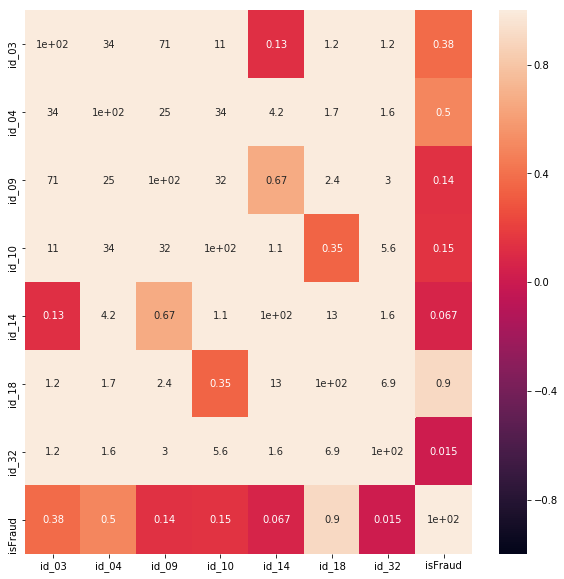

In [25]:
middle_null_id=[col for col in train_id.columns 
                   if train_id[col].isna().sum()/train_id.shape[0]>0.40]
merging_data2 = train_id[middle_null_id].merge(labels, how='right', left_index=True, right_index=True)
plt.figure(figsize=(10, 10))
heatmapid = sns.heatmap(abs(merging_data2.corr()*100), vmin=-1, vmax=1, annot=True)

In [26]:
prob_col=['M9','M8','M7','M5','M4','M3','M2','M1','id_30','id_33','id_34']
def delete_low_corr(data):
    '''delete data that has more than 80% missing values and less 70% correlation to the target'''
    big_null=[col for col in data.columns if data[col].isna().sum()/data.shape[0]>0.40 and col not in prob_col]
    merging_data = data[big_null].merge(labels, how='right', left_index=True, right_index=True)
    del_col=[col for col in merging_data.columns if abs(merging_data.corr().loc[col,'isFraud']*100)<4]
    data.drop(del_col, axis=1, inplace=True)
    return data
delete_low_corr(train_ts)
delete_low_corr(train_id)

train_ts.shape
train_id.shape

(144233, 25)

In [27]:
train_ts[[col for col in train_ts.columns if col in prob_col]].isnull().sum()/train_ts.shape[0]*100

M1    45.907136
M2    45.907136
M3    45.907136
M4    47.658753
M5    59.349409
M7    58.635317
M8    58.633115
M9    58.633115
dtype: float64

In [28]:
#train_ts.drop(['M5','M7','M8'], axis=1, inplace=True)

In [29]:
train_id[[col for col in train_id.columns if col in prob_col]].isnull().sum()/train_id.shape[0]*100

id_30    46.222432
id_33    49.187079
id_34    46.056034
dtype: float64

# Preprocessing

In [30]:
train=train_ts
train.head()
test_ts['days']=make_day_feature(test_ts, offset=0.58)
test_ts['hour']=make_hour_feature(test_ts)

In [31]:
fraud_data=train[train['isFraud']==1]
len_fraud_data=len(fraud_data)
notfraud_data=train[train['isFraud']==0][:len_fraud_data]
len(notfraud_data)

20663

,0,1
isFraud,0.96501,0.03499


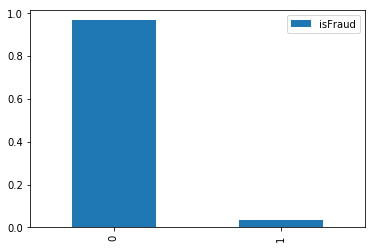

In [32]:
train_app=fraud_data.append(notfraud_data)
train_app=train_app.sample(frac=1)
train_app=train_app.reset_index(drop=True)
new_fraud_count = labels.value_counts(normalize=True).to_frame()
new_fraud_count.plot.bar()
new_fraud_count.T

In [33]:
labels=train_app['isFraud']
labels.shape

(41326,)

In [34]:
train_app.drop('isFraud', axis=1, inplace=True)

In [35]:
test=test_ts
test=test[train_app.columns]
test.shape
test.drop('TransactionID',axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Imputation**

In [36]:
# Append Train and Test Datasets
#df = train.append(test).reset_index()

# Cleanup
#del train, test
#gc.collect()

from sklearn.impute import SimpleImputer

def imputation(data):
    cat_col=[col for col in data.select_dtypes('object')]
    num_col=[col for col in data.select_dtypes('number')]
    for col in data.columns:
        if col in cat_col:
            if data[col].isnull().sum()/data.shape[0]*100<=30:
                if data[col].nunique()<=10:
                    cons_imputer=SimpleImputer(strategy='constant')
                    data[col]=cons_imputer.fit_transform(data[col].values.reshape(-1, 1))
                else:
                    mf_imputer=SimpleImputer(strategy='most_frequent')
                    data[col]=mf_imputer.fit_transform(data[col].values.reshape(-1, 1))
            else:
                cons_imputer=SimpleImputer(strategy='constant')
                data[col]=cons_imputer.fit_transform(data[col].values.reshape(-1, 1))
        if col in num_col:
            if data[col].isnull().sum()/data.shape[0]*100<=30:
                if data[col].nunique()<=10:
                    cons_imputer=SimpleImputer(strategy='constant')
                    data[col]=cons_imputer.fit_transform(data[col].values.reshape(-1, 1))
                else:
                    mf_imputer=SimpleImputer(strategy='median')
                    data[col]=mf_imputer.fit_transform(data[col].values.reshape(-1, 1))
            else:
                data[col].fillna(0)
    return data

imputation(train_app)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V314,V315,V316,V317,V318,V319,V320,V321,days,hour
0,3366525.0,9495384.0,500.000000,R,6019.0,583.0,150.0,visa,226.0,credit,...,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,4.0,21.0
1,3008059.0,536215.0,1956.000000,W,4272.0,111.0,150.0,visa,226.0,debit,...,0.0000,0.0000,0.0,0.0,0.0,1955.969971,1955.969971,1955.969971,5.0,4.0
2,3000205.0,380739.0,263.000000,W,15497.0,490.0,150.0,visa,226.0,debit,...,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.0,9.0
3,2990133.0,152692.0,5.980469,C,9026.0,545.0,185.0,visa,137.0,credit,...,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.0,18.0
4,2988543.0,135366.0,495.250000,W,15066.0,170.0,150.0,mastercard,102.0,credit,...,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41321,2989473.0,146410.0,28.765625,C,9026.0,545.0,185.0,visa,137.0,credit,...,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.0,16.0
41322,2989820.0,149775.0,50.000000,H,3682.0,264.0,150.0,visa,162.0,credit,...,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.0,17.0
41323,3006128.0,505387.0,68.500000,W,16255.0,470.0,150.0,mastercard,137.0,credit,...,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,5.0,20.0
41324,2995794.0,258084.0,47.937500,W,8320.0,476.0,150.0,visa,166.0,debit,...,57.9375,57.9375,0.0,0.0,0.0,0.000000,0.000000,0.000000,2.0,23.0


In [37]:
train_app.drop('TransactionID', axis=1, inplace=True)

In [38]:

def encoder(data):
    # Count encode all categorical features
    cat_col=data.select_dtypes('object')
    num_col=data.select_dtypes('number')
    for col in cat_col:
        data[col] = data[col].map(data[col].value_counts(dropna = False))
        # Count encode all other remaining 'Numerical' Features
    for col in [f for f in num_col if f not in ['index', 'TransactionDT', 'hour', 'days']]:
        data[col] = data[col].map(data[col].value_counts(dropna = False))
    return data
encoder(train_app)
encoder(test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V314,V315,V316,V317,V318,V319,V320,V321,days,hour
0,18403224,1256,360987,75,37346,435558,334882,256991,385021,1809,...,402663,413471,471485,452784,463263,478167,458214,471406,2.0,0.0
1,18403263,14235,360987,961,37346,435558,334882,256991,385021,38710,...,402663,413471,471485,452784,463263,478167,458214,471406,2.0,0.0
2,18403310,7273,360987,33,76,435558,334882,256991,385021,7226,...,402663,413471,471485,452784,463263,478167,22,471406,2.0,0.0
3,18403310,20,360987,839,11342,435558,334882,45790,385021,5300,...,2,6,471485,452784,463263,478167,458214,471406,2.0,0.0
4,18403317,4722,360987,1217,1332,435558,158169,21120,385021,32710,...,27,575,471485,452784,463263,478167,458214,471406,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,34214279,161,69266,2484,6684,53614,158169,71596,385021,1138,...,402663,413471,471485,452784,463263,478167,458214,471406,3.0,23.0
506687,34214287,166,69266,4639,9148,53614,158169,71596,385021,65609,...,9,13,471485,452784,463263,478167,458214,471406,3.0,23.0
506688,34214326,14235,360987,501,32351,435558,334882,256991,385021,7479,...,402663,413471,471485,452784,463263,478167,458214,471406,3.0,23.0
506689,34214337,127,360987,4,126,435558,158169,71596,385021,3954,...,402663,413471,471485,452784,463263,478167,458214,471406,3.0,23.0


As a last processing step I use a MinMaxScaler to scale all the features. For features with a large skew value this will also be corrected.

In [39]:
# Get Final Features

# Scale and correct extreme skew
def normalizer(data):
    feats = [f for f in data.columns if f not in ['index', 'TransactionDT', 'days', 'hour']]
    scaler = preprocessing.MinMaxScaler()
    for feat in feats:
        # Scale
        data[feat] = scaler.fit_transform(data[feat].values.reshape(-1, 1))
        # Correct Skew
        if data[feat].skew() > 10:
            data[feat] = np.log10(data[feat] + 1 - min(0, data[feat].min()))
    return data

normalizer(train_app)
normalizer(test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V314,V315,V316,V317,V318,V319,V320,V321,days,hour
0,18403224,0.045850,1.000000,0.005657,0.872649,1.000000,1.000000,1.000000,1.000000,0.027558,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,2.0,0.0
1,18403263,0.520020,1.000000,0.073383,0.872649,1.000000,1.000000,1.000000,1.000000,0.590004,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,2.0,0.0
2,18403310,0.265673,1.000000,0.002446,0.001753,1.000000,1.000000,1.000000,1.000000,0.110124,...,1.000000,1.000000,1.0,1.0,1.0,1.0,0.000046,1.0,2.0,0.0
3,18403310,0.000694,1.000000,0.064057,0.265008,1.000000,1.000000,0.178174,1.000000,0.080768,...,0.000002,0.000012,1.0,1.0,1.0,1.0,1.000000,1.0,2.0,0.0
4,18403317,0.172476,1.000000,0.092952,0.031102,1.000000,0.467746,0.082178,1.000000,0.498552,...,0.000065,0.001388,1.0,1.0,1.0,1.0,1.000000,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,34214279,0.005845,0.165484,0.189803,0.156163,0.123091,0.467746,0.278591,1.000000,0.017330,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,3.0,23.0
506687,34214287,0.006028,0.165484,0.354533,0.213740,0.123091,0.467746,0.278591,1.000000,1.000000,...,0.000020,0.000029,1.0,1.0,1.0,1.0,1.000000,1.0,3.0,23.0
506688,34214326,0.520020,1.000000,0.038220,0.755929,1.000000,1.000000,1.000000,1.000000,0.113980,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,3.0,23.0
506689,34214337,0.004603,1.000000,0.000229,0.002921,1.000000,0.467746,0.278591,1.000000,0.060252,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,3.0,23.0


In [40]:
train_app.shape

(41326, 217)

In [41]:
labels.shape[0]

41326

In [42]:
test.shape

(506691, 217)

Define the EarlyStopping, ModelCheckPoint and the model itself.

In [43]:
# Random Seed
seed = 12345
np.random.seed(seed)
random.seed(seed)

# Constants
epochs = 25
batch_size = 1024
number_of_folds = 6

In [44]:
def EarlyStop(patience):
    return EarlyStopping(monitor = "val_loss",
                          min_delta = 0,
                          mode = "min",
                          verbose = 1, 
                          patience = patience)

def ModelCheckpointFull(model_name):
    return ModelCheckpoint(model_name, 
                            monitor = 'val_loss', 
                            verbose = 1, 
                            save_best_only = True, 
                            save_weights_only = False, 
                            mode = 'min', 
                            period = 1)

# Input Shape
input_shape = train_app.shape[1]

# Define CNN 1D model
def create_model():
    model = Sequential()
    model.add(Conv1D(96, 2, activation = 'relu', input_shape=(input_shape,1), kernel_initializer = glorot_uniform(seed = seed)))
    model.add(BatchNormalization())       
    model.add(Dropout(0.25))
    model.add(Conv1D(96, 1, activation = 'relu', kernel_initializer = glorot_uniform(seed = seed)))
    model.add(BatchNormalization())       
    model.add(Flatten())
    model.add(Dropout(0.25))    
    model.add(Dense(96, activation = 'relu', kernel_initializer = glorot_uniform(seed = seed)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed = seed)))
    model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 0.001), metrics = ['accuracy'])
    
    return model

As a final step we run a Stratified KFold and generate the submission file. After some trials I found that about 25 epochs is a good value to use. When using more the validation AUC score will increase but the LB score will start to drop slightly.

In [45]:
# Reshape
train1 = train_app.values.reshape(-1, input_shape, 1)
test1 = test.values.reshape(-1, input_shape, 1)

In [46]:
test.shape

(506691, 217)

In [47]:
train1.shape

(41326, 217, 1)

In [48]:


# CV Folds
folds = StratifiedKFold(n_splits = number_of_folds, shuffle = True, random_state = seed)

# Arrays to store predictions
oof_preds = np.zeros(train1.shape[0])
sub_preds = np.zeros(test1.shape[0])

# Loop through folds
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train1, labels)):
    train_x, train_y = train1[train_idx], labels.iloc[train_idx]
    valid_x, valid_y = train1[valid_idx], labels.iloc[valid_idx]

    print('Running Fold: ' + str(n_fold))

    # CNN 1D model
    model = create_model()
    model.fit(train_x, train_y, 
                validation_data=(valid_x, valid_y), 
                epochs=epochs, 
                batch_size=batch_size, 
                verbose=0,
                callbacks=[EarlyStop(10), ModelCheckpointFull('model.h5')])

    # Delete Model
    del model
    gc.collect()

    # Reload Best Saved Model
    model = load_model('model.h5')

    # OOF Predictions
    oof_preds[valid_idx] = model.predict(valid_x).reshape(-1,)
    
    # Submission Predictions
    predictions = model.predict(test1).reshape(-1,)
    sub_preds += predictions / number_of_folds

    # Fold AUC Score
    print('Fold %2d AUC : %.6f' % (n_fold, roc_auc_score(valid_y, oof_preds[valid_idx])))        

    # Cleanup 
    del model, train_x, train_y, valid_y, valid_x
    K.clear_session()
    gc.collect

print('Full AUC score %.6f' % roc_auc_score(labels, oof_preds))

# Generate Submission
submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
submission['isFraud'] = sub_preds
submission.to_csv('submission.csv', index=False)

Running Fold: 0

Epoch 00001: val_loss improved from inf to 0.80112, saving model to model.h5

Epoch 00002: val_loss improved from 0.80112 to 0.63708, saving model to model.h5

Epoch 00003: val_loss improved from 0.63708 to 0.21794, saving model to model.h5

Epoch 00004: val_loss improved from 0.21794 to 0.09979, saving model to model.h5

Epoch 00005: val_loss improved from 0.09979 to 0.07930, saving model to model.h5

Epoch 00006: val_loss improved from 0.07930 to 0.07612, saving model to model.h5

Epoch 00007: val_loss did not improve from 0.07612

Epoch 00008: val_loss did not improve from 0.07612

Epoch 00009: val_loss did not improve from 0.07612

Epoch 00010: val_loss did not improve from 0.07612

Epoch 00011: val_loss did not improve from 0.07612

Epoch 00012: val_loss did not improve from 0.07612

Epoch 00013: val_loss did not improve from 0.07612

Epoch 00014: val_loss did not improve from 0.07612

Epoch 00015: val_loss did not improve from 0.07612

Epoch 00016: val_loss impro

I hope you enjoyed the notebook. Let me know if you have any feedback or questions.